# Model proliferation data with Gompertz law

Live cell population growth is modeled using the Gompertz law: $N = k e^{-e^{a-bt}}$.

In [1]:
import sys,os
import numpy as np
import pandas as pd
import scipy.optimize as optim
import functions
import glob
from scipy.stats import gamma
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

Specify study name and the casename (prefix for the proliferation data files).

In [2]:
cwd = os.getcwd()
data_directory = './data/Study1'
os.chdir(data_directory)

casename = 'growth_'

data_files = glob.glob(casename+'*.csv')


all_files = {}
times = []

for ff in data_files:
    t = float(ff.lstrip(casename).rstrip('.csv'))
    times.append(t)
    all_files[int(t)] = ff

times.sort()

In [3]:
p_array = np.zeros(shape=(len(data_files),10))
column_names = ['T','k','kerr1','kerr2','a','aerr1','aerr2','b','berr1','berr2']
parameters = pd.DataFrame(p_array,index=[i for i in range(0,len(data_files))],columns=column_names)

column_names = ['CT','T1','T1err1','T1err2','T2','T2err1','T2err2']
inflection_times = pd.DataFrame(np.zeros(shape=(len(data_files),7)),index=[i for i in range(0,len(data_files))],columns=column_names)
report_inflection_times = pd.DataFrame(np.zeros(shape=(len(data_files),7)),index=[i for i in range(0,len(data_files))],columns=column_names)

for idx in range(0,len(times)):
    t = times[idx]
    filename = all_files[int(t)]

    pop_series = pd.read_csv(filename)

    time_array = pop_series['Time (h)'].to_numpy()
    time_array = time_array.astype(float)
    time_size = time_array.shape[0]

    stack_size = time_size*(len(pop_series.columns.values)-1)

    time_stack = np.zeros(stack_size,)
    data_stack = np.zeros(stack_size,)

    time_l, data_l = [], []

    ik = 0

    n = len(pop_series.columns) - 2

    for col in pop_series.columns.values[1:]:
        this_data = pop_series[col].to_numpy()

        for p in range(0,this_data.shape[0]):
            if this_data[p]==this_data[p]:
                time_l.append(time_array[p])
                data_l.append(this_data[p])

    time_stack = np.array(time_l)
    data_stack = np.array(data_l)

    max_d = np.max(data_stack)

    max_inf_time = time_l[data_l.index(max_d)]

    m_d = max(data_l)
    t_inf = time_l[data_l.index(m_d)]

    check = 1
    iter = 0

    k_up, k_low = 2.0*m_d, 0.0
    b_up, b_low = 1.0/(time_array[1]-time_array[0]), 1.0/(time_array[-1]-time_array[0])
    a_up, a_low = max_inf_time*b_up, 0.0


    while check==1:
        all_bounds = (np.array([k_low,a_low,b_low]),np.array([k_up,a_up,b_up]))

        popt, pcov = optim.curve_fit(functions.gompertz,time_stack,data_stack,bounds=all_bounds)
        perr = np.sqrt(np.diag(pcov))

        check = 0

        iter += 1

    parameters.loc[idx,'T'] = t
    parameters.loc[idx,'k'] = popt[0]
    parameters.loc[idx,'a'] = popt[1]
    parameters.loc[idx,'b'] = popt[2]
    parameters.loc[idx,'kerr1'] = perr[0]
    parameters.loc[idx,'aerr1'] = perr[1]
    parameters.loc[idx,'berr1'] = perr[2]
    parameters.loc[idx,'kerr2'] = perr[0]
    parameters.loc[idx,'aerr2'] = perr[1]
    parameters.loc[idx,'berr2'] = perr[2]

    times_set = np.linspace(1,1000,10000)

    t1, t2 = functions.compute_gompertz_inflections(times_set,popt[0],popt[1],popt[2])
    
    inflection_times.loc[idx,'CT'] = t
    inflection_times.loc[idx,'T1'] = t1
    inflection_times.loc[idx,'T2'] = t2
    
    report_inflection_times.loc[idx,'CT'] = t
    report_inflection_times.loc[idx,'T1'] = t1
    report_inflection_times.loc[idx,'T2'] = t2

    T1_error = t1*(abs(perr[1]/popt[1]) + abs(perr[2]/popt[2]))

    up, low = functions.get_CI(t1,T1_error)
    
    inflection_times.loc[idx,'T1err1'] = up
    inflection_times.loc[idx,'T1err2'] = min(low,t1)

    report_inflection_times.loc[idx,'T1err1'] = max(t1 - low,0)
    report_inflection_times.loc[idx,'T1err2'] = t1 + up

    T2_error = t2*(abs(perr[1]/popt[1]) + abs(perr[2]/popt[2]))

    up, low = functions.get_CI(t2,T2_error)
    
    inflection_times.loc[idx,'T2err1'] = up
    inflection_times.loc[idx,'T2err2'] = min(low,t2)

    report_inflection_times.loc[idx,'T2err1'] = max(t2 - low,0)
    report_inflection_times.loc[idx,'T2err2'] = t2 + up

    rate_times = np.linspace(0.0,np.max(time_array),200)
    fit_N = functions.gompertz(rate_times,popt[0],popt[1],popt[2])

    total_data = np.zeros(shape=(rate_times.shape[0],2))
    total_data[:,0] = rate_times
    total_data[:,1] = fit_N

    np.savetxt('fit_'+filename,total_data,delimiter=',')

In [4]:
parameters.rename(columns={'kerr1': '+','aerr1': '+', 'berr1': '+'}, inplace=True)
parameters.rename(columns={'kerr2': '-','aerr2': '-', 'berr2': '-'}, inplace=True)

inflection_times.rename(columns={'T1err1': '+','T1err2': '-'}, inplace=True)
inflection_times.rename(columns={'T2err1': '+','T2err2': '-'}, inplace=True)

report_inflection_times.rename(columns={'T1err1': 'Lower CI','T1err2': 'Upper CI'}, inplace=True)
report_inflection_times.rename(columns={'T2err1': 'Lower CI','T2err2': 'Upper CI'}, inplace=True)

parameters.to_csv('gompertz_parameter_summary.csv',index=None)
inflection_times.to_csv('gompertz_inflection_points_summary.csv',index=None)

report_inflection_times.to_csv('gompertz_inflection_points_report.csv',index=None)

In [5]:
data_files = glob.glob(casename+'*.csv')

fit_data_files = glob.glob('fit_'+casename+'*.csv')

In [6]:
all_files = {}
times = []

for ff in data_files:
    t = float(ff.lstrip(casename).rstrip('.csv'))
    times.append(int(t))
    all_files[int(t)] = ff

times.sort()

In [7]:
ori_data = []
fit_data = []

for t in times:
    ori_data.append(pd.read_csv(casename+str(t)+'.csv').to_numpy())
    fit_data.append(pd.read_csv('fit_'+casename+str(t)+'.csv',header=None).to_numpy())

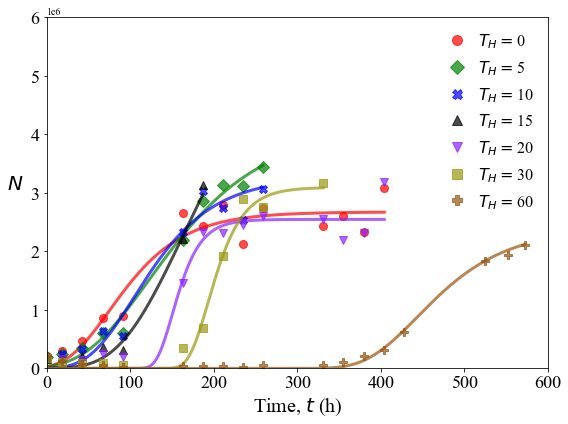

In [8]:
fig, axs = plt.subplots(figsize=(8,6))

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Times New Roman']

color_list = ['r','g','b','#000000','#8822ff','#999911','#995511']
marker_list = ['o','D','X','^','v','s','P']

for i in range(0,len(times)):
    c = color_list[i]
    plt.plot(ori_data[i][:,0],ori_data[i][:,1],marker=marker_list[i],ms=8,color=c,alpha=0.7,linewidth=0,label=r'$T_{H}= $'+str(times[i]))
    plt.plot(fit_data[i][:,0],fit_data[i][:,1],linewidth=3,color=c,alpha=0.7)
    
plt.xticks(size=18)
plt.yticks(size=18)  
plt.xlabel(r'Time, $t$ (h)',size=20)
plt.ylabel(r'$N$',size=20,rotation=0,labelpad=15)
plt.xlim(0,600)
plt.ylim(0,6000000)
plt.legend(frameon=False,prop={'size': 16},markerscale=1.25,handlelength=1.0)
plt.tight_layout()

os.chdir(cwd)